# Search based optimization

## Solving CartPole-v0 OpenAI

In this assignment you will use search based optimization algorithms in order to solve the OpenAI gym cartpole-V0 environment.
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the
pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
print('Dependencies loaded')

Dependencies loaded


In [3]:
logTraces = True
def trace(text:str):
    if logTraces:
        print(text)

## Random action based control

Run the cartpole for 1000 episodes. Control the cartpole by choosing random actions.

- For each episode register the number of successful timesteps.
- Plot a histogram of the number of successful timesteps. You can use the Seaborn distplot function for visualizing this histogram.
    > ![Results](./images/01-random-results.png)
- What is the average number of successful timesteps you achieve by taking random actions?
    > It varies between 20 and 30 typically

Average number of steps during experiment 22.922


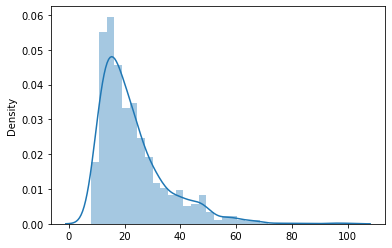

In [4]:
env = gym.make('CartPole-v1')
results = list()

for i_episode in range(1000):
    observation = env.reset()
    for t in range(100):
        #env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            results.append(t+1)
            #print("Episode finished after {} timesteps".format(t+1))
            break

env.close()
sns.distplot(results)
print("Average number of steps during experiment {}".format(sum(results) / len(results)))


## Angle based action control

Use the information about the angle of the pole to decide on the best action to take. If the pole is falling to the right, push the cart to the right. If the pole is falling to the left, push the cart to the left.
Again, run the cartpole for 1000 episodes.
- For each episode register the number of successful timesteps.
- Plot a histogram of the number of successful timesteps. You can use the Seaborn distplot function for visualizing this histogram.
    > ![Results](./images/02-angle-based-action-results.png)
- What is the average number of successful timesteps you achieved over these 1000 episodes?
    > It varies around 40

Average number of steps during experiment 42.243


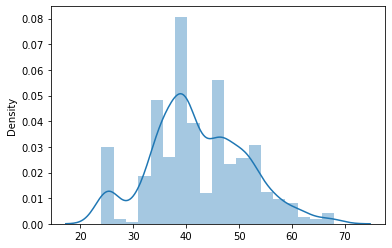

In [5]:
env = gym.make('CartPole-v1')
results = list()

for i_episode in range(1000):
    observation = env.reset()
    for t in range(100):
        angle = observation[2]
        if angle < 0:
            observation, reward, done, info = env.step(0)
        else:
            observation, reward, done, info = env.step(1)
        if done:
            results.append(t+1)
            break

env.close()
sns.distplot(results)
print("Average number of steps during experiment {}".format(sum(results) / len(results)))

## Random search based control

First define a vector of weights. Each of the weights corresponds to a one cartpole observation variable. The action will be based on the outcome of a linear combination of weights and observations.

Choose the action based on the following rule:

- Run 1000 iteration. For each iteration set the weights to a random value (in a realistic range) and evaluate these weights by running 20 episodes. The achieved reward for one iteration (and thus a weight vector) is the average reward over the 20 episodes. Store the history of iterations (average reward and the weight vector).
    > See first sub section.  Several runs achieve 200 (or 500, v1) average reward.
- Which weight vector yields the highest average reward?
    > Several ones get the highest reward.  You can easily see them in the sorted dataframe with all weights and their corresponding rewards
- Now test these best weights over 1000 episodes. What is the average reward you have achieved?
    > Again 200 maxed (or 500 with v1)
- Can you read from the weights which observation variables are important and which ones are not important in deciding which action to take?
    > It seems clear that angular velocity and angle have the biggest impact.  Position value seems to be less important.
- Make a 3D graph (scatterplot) showing which weight vectors achieve an average reward larger than 100 and which ones do not. To plot this graph you will put the 3 most important weights on the x,y,z axis. A red color indicates an average reward higher or equal than 100, black indicates an average reward lower than 100.

In [6]:
def computeActionByWeight(state, weights):
    p = np.matmul(weights, state)
    if p < 0:
        return 0
    else:
        return 1

In [7]:
def runEpisode(environment, weights, episode: int, iteration: int):
    observation = env.reset()
    trace(f'Running episode {episode} of iteration {iteration}')
    episodeReward = 0 
    done = False
    while not done:            
        action = computeActionByWeight(observation, weights)
        observation, reward, done, info = env.step(action)
        episodeReward = episodeReward + reward
    trace(f'Episode {episode} done with reward {episodeReward}')
    return episodeReward

### First run 1000 iterations to get best weights

Run 1000 iteration. For each iteration set the weights to a random value (in a realistic range) and evaluate these weights by running 20 episodes. The achieved reward for one iteration (and thus a weight vector) is the average reward over the 20 episodes. Store the history of iterations (average reward and the weight vector).

In [8]:
env = gym.make('CartPole-v1')
results = list()
logTraces = False
best_reward = 0
episodes = 20
iterations = 1000
for iteration in range(iterations):
    env.reset()
    weights = 2 * np.random.rand(4) - 1.0
    iterationReward = 0
    for episode in range(episodes):
        episodeReward = runEpisode(env, weights, episode, iteration)
        iterationReward = iterationReward + episodeReward

    iterationReward = iterationReward / episodes
    results.append({'iteration':iteration, 'avgreward': iterationReward, 
                   'w1_pos': weights[0],'w2_vlc': weights[1],'w3_angle': weights[2],'w4_angl_vlc': weights[3]})

    if iterationReward > best_reward:
        best_reward = iterationReward
        best_weights = weights

env.close()
output = pd.DataFrame(results)
output = output.sort_values(by='avgreward', ascending=False)
display(output)

,iteration,avgreward,w1_pos,w2_vlc,w3_angle,w4_angl_vlc
506,506,500.00,0.009422,0.600984,0.615450,0.946737
389,389,500.00,-0.116857,0.472401,0.088611,0.954292
164,164,500.00,0.475170,0.342575,0.974667,0.552728
969,969,500.00,0.338743,0.706397,0.776105,0.700382
130,130,500.00,0.039643,0.211533,0.946453,0.998167
...,...,...,...,...,...,...
246,246,8.65,0.195830,0.060841,-0.833590,-0.396892
15,15,8.65,0.471758,-0.781891,-0.274361,-0.771069
357,357,8.65,-0.149795,0.603042,-0.899584,0.175700
263,263,8.60,-0.254396,-0.005203,-0.927169,-0.976877


### Now we take the best weights from the previous run and will check the reward for 1000 episodes

In [9]:
env = gym.make('CartPole-v1')
env.reset()
logTraces = False
episodes = 1000
iterationReward = 0
for episode in range(episodes):
    episodeReward = runEpisode(env, best_weights, episode, 1)
    iterationReward = iterationReward + episodeReward

iterationReward = iterationReward / episodes
env.close()
print(f'The average reward for {episodes} episodes of the best weights is {iterationReward}')

The average reward for 1000 episodes of the best weights is 499.558


### Scatterplot

In [10]:
def define_scatter_color(reward):
    if reward > 100: 
        return 'red'
    else:
        return 'black'

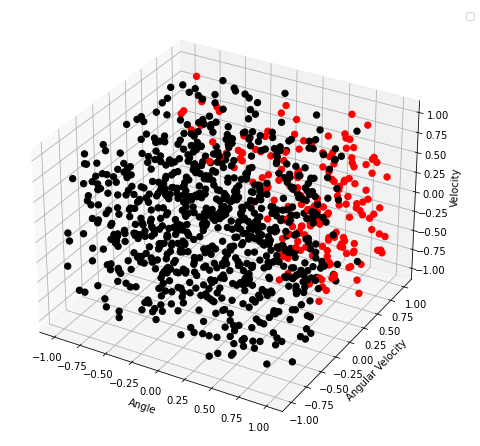

In [11]:
import re, seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

output['color'] = output.apply (lambda row: define_scatter_color(row['avgreward']), axis=1)
x = output[['w3_angle']].to_numpy()
y = output[['w4_angl_vlc']].to_numpy()
z = output[['w2_vlc']].to_numpy()
c = output[['color']].to_numpy().reshape(1000)
# plot
sc = ax.scatter(x, y, z, s=40, c=c, marker='o', alpha=1)
ax.set_xlabel('Angle')
ax.set_ylabel('Angular Velocity')
ax.set_zlabel('Velocity')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

## Hill climbing

Implement the hill climbing algorithm to find a good weight vector. You start with a random weight vector. Each iteration you slightly change the weight vector by adding some noise (can be taken from a normal distribution with mean 0 and standard deviation sigma. If the new weight
vector results in a higher reward (for example over 20 episodes) then you can keep the new weight vector. Otherwise you stick to the old one.
- Run 1000 iteration. For each iteration set the weights to a random value (in a realistic range) and evaluate these weights by running 20 episodes. The achieved reward for one iteration (and thus a weight vector) is the average reward over the 20 episodes. Store the history of iterations (average reward and the weight vector).
- Which weight vector yields the highest average reward?
- Now test these best weights over 1000 episodes. What is the average reward you have achieved? Plot the histogram of the rewards.

> Answers to the above are quite similar to the previous example, because weights and conclusions are quite similar.  Again the max reward is easily achieved, so not so much differences between different approaches on the results



### Using an agent class, for 1000 iterations to get best weights

This is inspired by https://github.com/the-computer-scientist/OpenAIGym/blob/master/HillClimbingInOpenAIGym.ipynb

In [51]:
class HillClimbingAgent():
    def __init__(self, env):
        self.shape = env.observation_space.shape
        self.action_count = env.action_space.n
        self.initialize()
        
    def initialize(self):
        # Random initialization of weights
        self.weights = 1e-4*np.random.rand(*self.shape, self.action_count)
        self.best_reward = -np.Inf
        self.best_weights = np.copy(self.weights)
        self.noise_scale = 1e-2
        
    def initialize_weights(self, weights):
        # Random initialization of weights
        self.weights = weights
        self.best_weights = np.copy(self.weights)
        
    def get_action(self, state):
        # Calculate action, based on the state & weights
        p = np.dot(state, self.weights)
        action = np.argmax(p)
        return action
    
    def update_model(self, reward):
        if reward >= self.best_reward:
            # Better reward to save
            self.best_reward = reward
            self.best_weights = np.copy(self.weights)
            # Adapt noise_scale to smaller value, 
            # keeping it high enough to move
            self.noise_scale = max(self.noise_scale/2, 1e-3)
        else:
            # Adapt noise_scale to larger value, 
            # keeping it small enough to not move to far
            self.noise_scale = min(self.noise_scale*2, 2)
        
        # Randomly adjust weights
        self.weights = self.best_weights + self.noise_scale * np.random.rand(*self.shape, self.action_count)
        


In [54]:
num_episodes = 20
num_iterations = 1000
results = list()
best_weights = None
best_reward = 0
for iteration in range(num_iterations):
    iterationReward = 0
    env.reset()
    agent = HillClimbingAgent(env)
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward

        agent.update_model(total_reward)
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        iterationReward = iterationReward + total_reward
    
    if iterationReward > best_reward:
        best_weights = agent.best_weights
    
    iterationReward = iterationReward / episodes
    results.append({'iteration':iteration, 'avg_reward': iterationReward, 
                   'w1_pos': agent.best_weights[0],'w2_vlc': agent.best_weights[1],'w3_angle': agent.best_weights[2],'w4_angl_vlc': agent.best_weights[3]})

output = pd.DataFrame(results)
output = output.sort_values(by='avg_reward', ascending=False)
display(output)


,iteration,avg_reward,w1_pos,w2_vlc,w3_angle,w4_angl_vlc
418,418,459.95,"[0.01843178406612308, 0.019189248650338928]","[0.009578408504886995, 0.014213057684792817]","[0.011141761496704568, 0.018721074076653875]","[0.012970742252010751, 0.01745425522487696]"
993,993,455.10,"[0.013406872828420947, 0.013969076090323943]","[0.0126433978516795, 0.013555954385047765]","[0.010842182964610004, 0.018028733293591226]","[0.011494716283725859, 0.014765608403405307]"
21,21,454.55,"[0.013643680878464903, 0.014403121563084473]","[0.016509028257737143, 0.02015391692061247]","[0.013735501159002248, 0.020643647320283395]","[0.012650069805267807, 0.017828198567235453]"
55,55,452.45,"[0.015043366320780628, 0.014595658231476141]","[0.011229573833713627, 0.012825651704568999]","[0.010371246805794477, 0.01466340967469944]","[0.010029163489538483, 0.017089273902594102]"
664,664,452.40,"[0.011673324405808363, 0.010885201878714907]","[0.01108498843176144, 0.013765538204003369]","[0.009088349951716573, 0.01610026541883936]","[0.009875844974031838, 0.01789251013375689]"
...,...,...,...,...,...,...
909,909,9.25,"[0.018639367145769064, 0.014912741577108243]","[0.019290899584789738, 0.029278578919250255]","[0.020884707023445876, 0.026233367261576747]","[0.02704033167071399, 0.024796542501871167]"
568,568,9.15,"[0.0159649498477157, 0.01772175658467722]","[0.02559327595780615, 0.018107416147389248]","[0.02944147162647693, 0.019026436274107193]","[0.023760145685141926, 0.021662482308715952]"
526,526,9.15,"[0.016563848494449213, 0.016755155295299896]","[0.013368640924819382, 0.017109781348334005]","[0.020671688138474274, 0.013382317456972482]","[0.01995871957922781, 0.01433570633008971]"
424,424,9.10,"[1.1312089449824363, 1.6773296848259998]","[0.7673628264592587, 0.6339724281842471]","[0.8228898753670124, 1.7986931324136108]","[2.217601697934778, 0.8080597501186931]"


### Plotting the average reward histogram

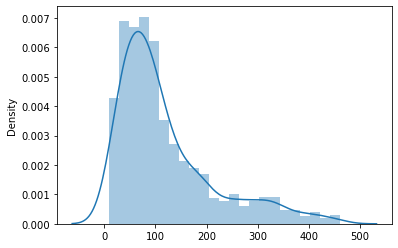

In [55]:
_ = sns.distplot(output[['avg_reward']].to_numpy())

### Taking the best weights and run 1000 episodes

In [56]:
env.reset()
agent = HillClimbingAgent(env)
agent.initialize_weights(best_weights)
for ep in range(1000):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        state, reward, done, info = env.step(action)
        total_reward += reward

print(f'Total reward for best weights: {total_reward}')

Total reward for best weights: 111.0


## Simulated annealing

Now change the hill climbing algorithm to simulated annealing. Also here you will run 1000 iterations with 20 episodes per iteration.
- Set a starting temperature and a cooling rate.
- Randomly change the weights and evaluate the current reward Rt.
- If the current reward Rt is higher than the previous reward Rt-1 keep the new weights (hill climbing). where .
- Gradually lower the temperature.
- Run 1000 iteration. For each iteration set the weights to a random value (in a realistic range) and evaluate these weights by running 20 episodes. The achieved reward for one iteration (and thus a weight vector) is the average reward over the 20 episodes. Store the history of iterations (average reward and the weight vector).
- Which weight vector yields the highest average reward?
- Now test these best weights over 1000 episodes. What is the average reward you have achieved? Plot the histogram of the rewards.

In [73]:
class SimmulatedAnnealingAgent():
    def __init__(self, env, temperature=100000, cooling_rate=0.993, spread=0.001):
        self.shape = env.observation_space.shape
        self.action_count = env.action_space.n
        self.temperature = temperature  # Learning rate
        self.cooling_rate = cooling_rate  # Decay in impact of temperature
        self.spread = spread  # Spread of randomness when selecting new values to test

        self.initialize()
        
    def initialize(self):
        # Random initialization of weights
        self.weights = 1e-4*np.random.rand(*self.shape, self.action_count)
        self.best_reward = -np.Inf
        self.best_weights = np.copy(self.weights)
        self.noise_scale = 1e-2
        
    def initialize_weights(self, weights):
        # Random initialization of weights
        self.weights = weights
        self.best_weights = np.copy(self.weights)
        
    def get_action(self, state):
        # Calculate action, based on the state & weights
        p = np.dot(state, self.weights)
        action = np.argmax(p)
        return action
    
    def update_model(self, reward):
        if reward >= self.best_reward:
            # Better reward to save
            self.best_reward = reward
            self.best_weights = np.copy(self.weights)
        else:
            reward_difference = (reward - best_reward)
            p = np.exp(reward_difference/self.temperature)
            if np.random.rand() < p:
                self.best_reward = reward
                self.best_weights = self.weights
        
        # Randomly adjust weights
        self.weights = self.best_weights + np.random.normal(loc=0,scale= self.spread) 
        self.temperature = self.cooling_rate * self.temperature

In [74]:
num_episodes = 20
num_iterations = 1000
results = list()
best_weights = None
best_reward = 0
for iteration in range(num_iterations):
    iterationReward = 0
    env.reset()
    agent = SimmulatedAnnealingAgent(env)
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward

        agent.update_model(total_reward)
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        iterationReward = iterationReward + total_reward
    
    if iterationReward > best_reward:
        best_weights = agent.best_weights
    
    iterationReward = iterationReward / episodes
    results.append({'iteration':iteration, 'avg_reward': iterationReward, 
                   'w1_pos': agent.best_weights[0],'w2_vlc': agent.best_weights[1],'w3_angle': agent.best_weights[2],'w4_angl_vlc': agent.best_weights[3]})

output = pd.DataFrame(results)
output = output.sort_values(by='avg_reward', ascending=False)
display(output)


,iteration,avg_reward,w1_pos,w2_vlc,w3_angle,w4_angl_vlc
963,963,500.00,"[0.00048082805941620783, 0.0004779361088813759]","[0.0004301440354435727, 0.0004480473303500093]","[0.0004388586367759749, 0.00047940308900509885]","[0.00045960007401089366, 0.00048165862977164547]"
78,78,500.00,"[-0.0017323853972160755, -0.0017277257736339298]","[-0.0017281445555149136, -0.0017066640494773503]","[-0.0017296661882747677, -0.0017081680510310122]","[-0.001767977244146673, -0.001744603378011053]"
359,359,500.00,"[-0.0005446165070379282, -0.0005367516985413328]","[-0.0005466502958073948, -0.0005440958412517213]","[-0.0005230030374690277, -0.000476980424516594]","[-0.000546245369496335, -0.0005338170342338197]"
617,617,500.00,"[0.0012996819972521296, 0.0012987238874499131]","[0.001261489000091717, 0.0012898493943839372]","[0.0012623664733844742, 0.0013338347766330618]","[0.0012800738239926856, 0.0013153402972305719]"
16,16,500.00,"[0.0021342716670168264, 0.002115835701337075]","[0.0020963512322657142, 0.002155960106052966]","[0.0020937832728005, 0.0021699818696718333]","[0.002097709463817673, 0.002160579456297324]"
...,...,...,...,...,...,...
329,329,8.65,"[-0.0007651378184016665, -0.0008058439279037038]","[-0.0007890496806219271, -0.0007599805315289209]","[-0.0007536718347935453, -0.0008231703661303283]","[-0.000769578044448128, -0.0007589915538810386]"
337,337,8.60,"[-0.0012244827218250752, -0.0011856979564531952]","[-0.0012077259464266447, -0.001176293786939305]","[-0.0011803553230365347, -0.0012108023663236068]","[-0.0011513872112937766, -0.001144544738848586]"
907,907,8.60,"[-0.0029736747855068583, -0.0029673830671130327]","[-0.0030169997765917235, -0.0029914571351056813]","[-0.002929054519985992, -0.0030010830395307215]","[-0.0030107957696826415, -0.003004778732285149]"
729,729,8.55,"[0.006241867639590847, 0.006175025273667957]","[0.006166995747203648, 0.006200555202718986]","[0.006262002225001463, 0.006168599576724899]","[0.0062069305254357065, 0.006189338333035612]"


## Adaptive noise scaling

Modify the simulated annealing algorithm in the following way:
Reduce the standard deviation of the distribution we sample the noise from when the new reward is higher than the previous reward. Otherwise increase the standard deviation. For example you can half or double the standard deviation. It’s up to you to find a good value for the scaling factor.
- Run 1000 iteration. For each iteration set the weights to a random value (in a realistic range) and evaluate these weights by running 20 episodes. The achieved reward for one iteration (and thus a weight vector) is the average reward over the 20 episodes. Store the history of iterations (average reward and the weight vector).
- Which weight vector yields the highest average reward?
- Now test these best weights over 1000 episodes. What is the average reward you have achieved? Plot the histogram of the rewards.

In [76]:
class AdaptiveNoiseScalingAgent():
    def __init__(self, env, temperature=100000, cooling_rate=0.993, spread=0.001):
        self.shape = env.observation_space.shape
        self.action_count = env.action_space.n
        self.temperature = temperature  # Learning rate
        self.cooling_rate = cooling_rate  # Decay in impact of temperature
        self.spread = spread  # Spread of randomness when selecting new values to test

        self.initialize()
        
    def initialize(self):
        # Random initialization of weights
        self.weights = 1e-4*np.random.rand(*self.shape, self.action_count)
        self.best_reward = -np.Inf
        self.best_weights = np.copy(self.weights)
        self.min_spread = 1e-4
        self.max_spread = 1
        self.noise_scale = 1e-2
        
    def initialize_weights(self, weights):
        # Random initialization of weights
        self.weights = weights
        self.best_weights = np.copy(self.weights)
        
    def get_action(self, state):
        # Calculate action, based on the state & weights
        p = np.dot(state, self.weights)
        action = np.argmax(p)
        return action
    
    def update_model(self, reward):
        if reward >= self.best_reward:
            # Better reward to save
            self.spread = max(self.spread/2, self.min_spread)
            self.best_reward = reward
            self.best_weights = np.copy(self.weights)
        else:
            reward_difference = (reward - best_reward)
            p = np.exp(reward_difference/self.temperature)
            if np.random.rand() < p:
                self.best_reward = reward
                self.best_weights = self.weights
                self.spread = min(self.spread*2, self.max_spread)
                
        
        # Randomly adjust weights
        self.weights = self.best_weights + np.random.normal(loc=0,scale= self.spread) 
        self.temperature = self.cooling_rate * self.temperature
    

In [77]:
num_episodes = 20
num_iterations = 1000
results = list()
best_weights = None
best_reward = 0
for iteration in range(num_iterations):
    iterationReward = 0
    env.reset()
    agent = AdaptiveNoiseScalingAgent(env)
    
    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward

        agent.update_model(total_reward)
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        iterationReward = iterationReward + total_reward
    
    if iterationReward > best_reward:
        best_weights = agent.best_weights
    
    iterationReward = iterationReward / episodes
    results.append({'iteration':iteration, 'avg_reward': iterationReward, 
                   'w1_pos': agent.best_weights[0],'w2_vlc': agent.best_weights[1],'w3_angle': agent.best_weights[2],'w4_angl_vlc': agent.best_weights[3]})

output = pd.DataFrame(results)
output = output.sort_values(by='avg_reward', ascending=False)
display(output)


,iteration,avg_reward,w1_pos,w2_vlc,w3_angle,w4_angl_vlc
111,111,500.00,"[0.0004195094959531857, 0.0004228708601564977]","[0.0003556685956578452, 0.0003727685870160271]","[0.0003949108455081987, 0.00042921354162113646]","[0.00039171390364399575, 0.0004444299728363807]"
303,303,500.00,"[0.0004856389344717497, 0.0004904290936966635]","[0.00046892093135958, 0.00046591574555840875]","[0.0004484135833014611, 0.0005214384712490805]","[0.0004482798351113056, 0.0004976354120586874]"
822,822,500.00,"[-7.467633103883763e-05, -5.458433080257991e-05]","[-1.859341542942074e-05, -9.580422602610566e-06]","[-7.136769105653742e-05, 2.2509894164673223e-06]","[-4.4031804826603175e-05, -3.245212100972841e-05]"
235,235,500.00,"[-0.0002033183255811779, -0.00021166671467779733]","[-0.0002506886427399998, -0.00020969004843725392]","[-0.0002502278130857439, -0.0002133163748044418]","[-0.00024294751320590898, -0.0001982566077951537]"
887,887,500.00,"[-0.0009122898109517994, -0.0008997425145515953]","[-0.0008602005574908833, -0.0008514205093858051]","[-0.0009290851444236927, -0.0008508609614658815]","[-0.0009333888398734723, -0.0009105255843621219]"
...,...,...,...,...,...,...
944,944,8.70,"[-4.460834094281555e-05, -8.680076250915355e-05]","[-7.496427022504097e-05, -4.032267789894273e-05]","[-3.7888249516696334e-05, -0.00010824193944544...","[-4.952259519860588e-05, -8.175704173518544e-05]"
688,688,8.70,"[-0.0004314890209379452, -0.0004665881327863143]","[-0.00043389474678203393, -0.0004429537378745965]","[-0.0003900083919249346, -0.00047986645549005156]","[-0.0004248278984752, -0.00045438838482891284]"
976,976,8.65,"[0.0009522144579193077, 0.0009182242149466724]","[0.0009277367175019202, 0.0009483303017757068]","[0.0009506000806533301, 0.0009073512622986614]","[0.0009475630042784759, 0.0009002934013443178]"
204,204,8.65,"[-5.529109055466241e-05, -4.371540408022609e-05]","[-2.845739940357208e-05, -4.850666150794122e-06]","[-8.881532209457845e-06, -4.341391676869656e-05]","[-5.685372822167935e-05, -5.808990468898989e-05]"


## Extensions & conclusions

How do these different search algorithms compare to or differ from each other in terms of reward and computational efficiency?
- Check if you can solve the cartpole-V1 environment. This environment has a maximum number of episodes steps of 500 where the cartpole-V0 is limited to 200 episode steps.
    > Was easy to do and it worked as well.  Several times reached the 500 max reward as well
- Does it make sense to increase the number of observation variables by deriving new observations from the existing ones? Think of it as feature expansion in machine learning.
    > It does not seem to make sense, as we just work linear and also we have just reached max reward easily
- Consider the MountainCar-v0 environment. Argument whether or not it is possible 